In [1]:
!pip install datasets transformers langchain einops accelerate evaluate

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [3]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
import evaluate
from datasets import load_dataset, Dataset
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.nn import softmax
from sklearn.metrics import confusion_matrix
from transformers import Trainer, EarlyStoppingCallback, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification

class_labels = {0: 'false', 1: 'half-true', 2: 'mostly-true', 3: 'true', 4: 'barely-true', 5: 'pants-fire'}
class_labels_binary = {'false': 0, 'half-true': 0, 'barely-true': 0, 'pants-fire': 0, 'true': 1, 'mostly-true': 1}

binary_mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0}

palette = sns.color_palette('hls')
truth_palette = sns.color_palette('hls', 15)[:6]
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [4]:
def load_data(path, split=None, remove_all=True, concat=False, max_len=75):
    # Function to map labels to binary labels
    def map_labels(example):
        example['binary_label'] = binary_mapping.get(example['label'], None)
        return example

    def create_label_name(split):
        col = split.pop('label')
        split['label_name'] = col.map(class_labels)
        split['label'] = col
        return split

    if split is not None:
        dataset = load_dataset(path, split=split)
        split_df = pd.DataFrame(dataset)
        split_df = create_label_name(split_df)
        print(f'Size of {split} split:', len(split_df))
        return split_df

    dataset = load_dataset(path)

    dataset['train'] = dataset['train'].map(map_labels)
    dataset['test'] = dataset['test'].map(map_labels)
    dataset['validation'] = dataset['validation'].map(map_labels)

    if concat:
        for split in ['train', 'test', 'validation']:
            dataset[split] = dataset[split].map(
                lambda example: {'statement': example['statement'][:max_len] if len(example['statement']) > max_len else example['statement']}
            )

            text_col = dataset[split]['statement']
            subject_col = dataset[split]['subject']
            speaker_col = dataset[split]['speaker']
            context_col = dataset[split]['context']

            concatenated_texts = [f"{text} [SEP] {subject} [SEP] {speaker} [SEP] {context}" for text, subject, speaker, context in zip(text_col, subject_col, speaker_col, context_col)]

            # Create a new Dataset object with the additional 'text' column
            dataset[split] = dataset[split].map(
                lambda example, idx: {'text': concatenated_texts[idx]},
                with_indices=True
            )

    if remove_all:
        cols_to_remove = dataset['train'].column_names
        cols_to_remove.remove("text")
        cols_to_remove.remove("binary_label")
        # cols_to_remove.remove("label")
        dataset = dataset.remove_columns(cols_to_remove)
    else:
        dataset = dataset.remove_columns(['label'])

    dataset = dataset.rename_column('binary_label', 'label')

    # return splits
    return dataset

def get_dataframes_from_splits(splits):
    train_df = pd.DataFrame(splits['train'][['statement', 'label']])
    test_df = pd.DataFrame(splits['test'][['statement', 'label']])
    val_df = pd.DataFrame(splits['validation'][['statement', 'label']])

    # train_df['class'] = train_df['label'].map(class_labels_binary).astype(np.int32)
    # test_df['class'] = test_df['label'].map(class_labels_binary).astype(np.int32)
    # val_df['class'] = val_df['label'].map(class_labels_binary).astype(np.int32)

    return train_df, test_df, val_df

def balance_dataset(dataset, split='train'):
    # Separate features and labels
    if 'text' not in dataset[split].column_names:
        X = np.array(dataset[split]['statement'])
    else:
        X = np.array(dataset[split]['text'])
    y = np.array(dataset[split]['label'])

    # Reshape the features
    X_reshaped = X.reshape(-1, 1)

    # Apply undersampling to balance the classes based on the minority class
    sampler = RandomUnderSampler(sampling_strategy='auto')
    X_resampled, y_resampled = sampler.fit_resample(X_reshaped, y)

    # Create a new balanced dataset
    balanced_dataset = Dataset.from_dict({
        'text': X_resampled.squeeze(1),
        'label': y_resampled
    })

    return balanced_dataset

def display_samples(dataset, num_samples=5):
    data = dataset.shuffle(seed=42).select(range(num_samples))

    for example in data:
        print(example['text'], example['label'])

def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

def evaluate_performance(trainer, inputs):
    # basic evaluation of model
    trainer.evaluate(inputs)

    # get label probability prediction
    y_pred = trainer.predict(inputs)
    y_proba = softmax(y_pred.predictions)

    # get predicted labels and true labels
    y_true_labels = y_pred.label_ids
    y_pred_labels = np.argmax(y_proba, axis=1)

    for metric in [evaluate.load("f1"), evaluate.load("recall"), evaluate.load("precision")]:
        print(metric.compute(predictions=y_pred_labels, references=y_true_labels))

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    sns.heatmap(cm, annot=True)
    plt.show()

In [5]:
dataset = load_data(path='liar', remove_all=True, concat=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
trainset = balance_dataset(dataset, split='train')
testset = dataset['test']
valset = dataset['validation']

In [ ]:
# for data in [trainset, testset, valset]:
#     df = pd.DataFrame(data)
#     plt.figure(figsize=(8, 5))
#     plot = sns.countplot(x=df['text'].str.len(), data=df)

#     num_ticks = 10
#     x_values = range(len(plot.get_xticks()))
#     x_tick_indices = [int(i * (len(x_values) - 1) / (num_ticks - 1)) for i in range(num_ticks)]
#     x_tick_labels = [plot.get_xticks()[i] for i in x_tick_indices]
#     plt.xticks(x_tick_indices, x_tick_labels)
#     plt.tight_layout()  # Adjusts spacing between plot elements
#     plt.xlabel("String Length")
#     plt.ylabel("Count")
#     plt.title("Distribution of String Length")
#     plt.show()

#     print(df['text'].str.len().quantile(.5))

In [8]:
display_samples(trainset, num_samples=3)

Taxpayers earning $1 million pay an effective tax rate that is about four t [SEP] taxes [SEP] declan-oscanlon [SEP] an opinion piece in the Star-Ledger 1
The wife of the Ferguson, Mo., police chief said African-Americans in Fergu [SEP] city-government,crime,criminal-justice,families,human-rights,urban [SEP] tweets [SEP] posts on Twitter 0
Odd fact for odd draft: No. 2 overall pick will earn more than the No. 1 pi [SEP] sports,taxes [SEP] adam-schefter [SEP] a tweet about the NFL Draft 1


In [9]:
display_samples(testset, num_samples=3)

Says New START, passed while Clinton was secretary of state, is a treaty cu [SEP] candidates-biography,foreign-policy,nuclear [SEP] hillary-clinton [SEP] a television ad 1
Says Ohio Rep. Marcy Kaptur actually lives in a fancy condo in the Washingt [SEP] congress,elections,job-accomplishments,message-machine-2012 [SEP] campaign-primary-accountability [SEP] a campaign commercial 0
"John McCain decided to stand with George Bush 95 percent of the time (last [SEP] bush-administration [SEP] barack-obama [SEP] St. Paul, Minn. 1


In [10]:
display_samples(valset, num_samples=3)

Sheldon Whitehouse [got] a secret closed-door briefing, warning of the [200 [SEP] bankruptcy,bush-administration,candidates-biography,congress,congressional-rules,corporations,economy,ethics,financial-regulation,government-regulation,history,legal-issues,message-machine-2012,campaign-advertising [SEP] peoples-majority [SEP] a TV commercial 0
Were up 123,000 jobs over the last year and three-quarters. Were actually,  [SEP] economy,jobs [SEP] john-kasich [SEP] a television interview 1
Says the New York Giants train in New Jersey, they play in New Jersey and m [SEP] sports [SEP] chris-christie [SEP] an interview on “Meet the Press” 1


In [19]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_dataset(data):
    return tokenizer(data['text'],
                     max_length=100,
                     truncation=True,
                     padding="max_length")

train_dataset = trainset.map(tokenize_dataset)
test_dataset = testset.map(tokenize_dataset)
val_dataset = valset.map(tokenize_dataset)

Map:   0%|          | 0/8994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

In [15]:
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weigh

In [16]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./sentiment_transfer_learning_transformer/",
    logging_dir='./sentiment_transfer_learning_transformer/logs',
    logging_strategy='epoch',
    logging_steps=100,
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [20]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.660300,0.651491,0.615744
2,0.644100,0.661601,0.610288


TrainOutput(global_step=282, training_loss=0.6521858864642204, metrics={'train_runtime': 168.2482, 'train_samples_per_second': 267.284, 'train_steps_per_second': 4.19, 'total_flos': 465395227934400.0, 'train_loss': 0.6521858864642204, 'epoch': 2.0})

{'f1': 0.639225181598063}
{'recall': 0.6457638425617078}
{'precision': 0.6328176073218567}


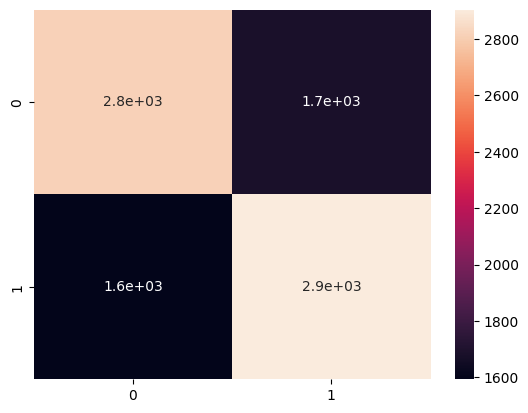

In [23]:
evaluate_performance(trainer, train_dataset)

{'f1': 0.6535488404778638}
{'recall': 0.6396148555708391}
{'precision': 0.6681034482758621}


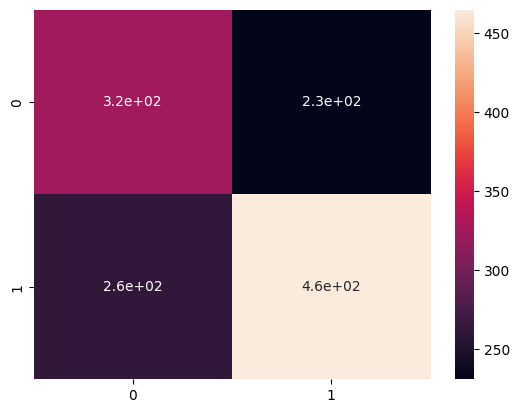

In [24]:
evaluate_performance(trainer, test_dataset)

{'f1': 0.6466616654163541}
{'recall': 0.6452095808383234}
{'precision': 0.6481203007518797}


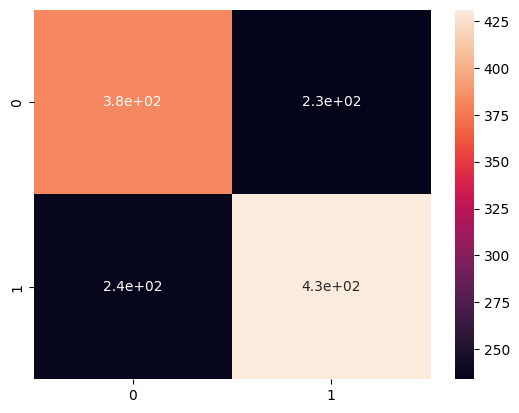

In [25]:
evaluate_performance(trainer, val_dataset)